In [366]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
import time

from pathlib import Path
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torchsummary import summary

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [117]:
# label encode categories

class_names = sorted([x.name for x in Path('intel-image-classification/seg_train/seg_train/').iterdir()])
class_names_labels = {class_name : i for i, class_name in enumerate(class_names)}
labels_to_class = {i : class_name for class_name, i in class_names_labels.items()}

In [118]:
class_names_labels

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [4]:
def image_df(data_split):
    
    '''setup image dataframe holding path and label'''
    
    if data_split == 'train':
        data_path = Path('intel-image-classification/seg_train/seg_train/')
    elif data_split == 'test':
        data_path = Path('intel-image-classification/seg_test/seg_test/')
    
    save = []
    images = data_path.glob('*/*.jpg')
    
    for image in images:
        img_path = str(image)
        label = image.parts[-2]
        fn = image.name
        save.append([fn, img_path, label])
        
    df = pd.DataFrame(save, columns=['fn', 'path', 'label'])
    df['label_num'] = df['label'].map(class_names_labels)
    
    return df
    

In [5]:
train_df = image_df('train')
train_df.head()

fn                                               path      label  \
0  14731.jpg  intel-image-classification/seg_train/seg_train...  buildings   
1   5327.jpg  intel-image-classification/seg_train/seg_train...  buildings   
2   2385.jpg  intel-image-classification/seg_train/seg_train...  buildings   
3   7593.jpg  intel-image-classification/seg_train/seg_train...  buildings   
4   7846.jpg  intel-image-classification/seg_train/seg_train...  buildings   

   label_num  
0          0  
1          0  
2          0  
3          0  
4          0

In [6]:
test_df = image_df('test')
test_df.head()

fn                                               path      label  \
0  23106.jpg  intel-image-classification/seg_test/seg_test/b...  buildings   
1  22810.jpg  intel-image-classification/seg_test/seg_test/b...  buildings   
2  22691.jpg  intel-image-classification/seg_test/seg_test/b...  buildings   
3  22586.jpg  intel-image-classification/seg_test/seg_test/b...  buildings   
4  20430.jpg  intel-image-classification/seg_test/seg_test/b...  buildings   

   label_num  
0          0  
1          0  
2          0  
3          0  
4          0

number of training examples: 14034
number of test examples: 3000
image size: (150, 150, 3)


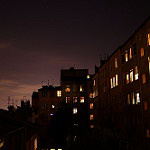

In [7]:
# eda
print('number of training examples: {}'.format(train_df.shape[0]))
print('number of test examples: {}'.format(test_df.shape[0]))

example_img = Image.open(train_df['path'].values[0])
print('image size: {}'.format(np.array(example_img).shape))
example_img

In [8]:
# distribution of label

def plot_label_dist(df, title):
    
    counts = df['label'].value_counts(normalize=True, sort=True).to_frame().reset_index()
    counts.columns = ['label', 'freq']
    
    x = range(counts.shape[0])
    bars = plt.bar(x, counts['freq'], width=0.6)
    plt.xticks(x, counts['label'], rotation=30)
    plt.title(title)
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(x)))
    
    # set color and label
    for i, (bar, label) in enumerate(zip(bars, counts['label'])):
        bar.set_color(colors[class_names_labels[label]])
        bar.set_edgecolor('k')
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, 1.02 * height,
                 '{:.2f}'.format(height), ha='center', va='bottom')
    
    # set ylim
    ylim = plt.gca().get_ylim()
    plt.ylim(ylim[0], ylim[1]*1.1)
    plt.ylabel('Frequency')
    plt.grid(alpha=0.2)

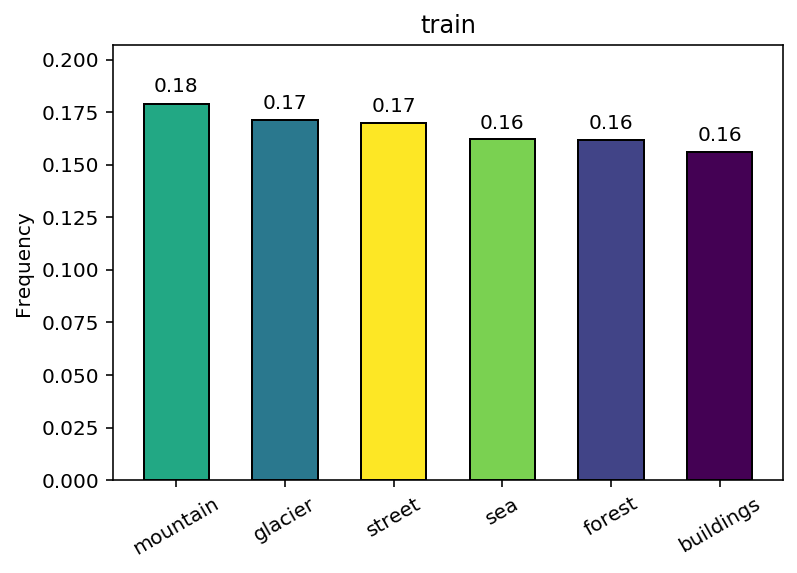

In [9]:
plot_label_dist(train_df, 'train')

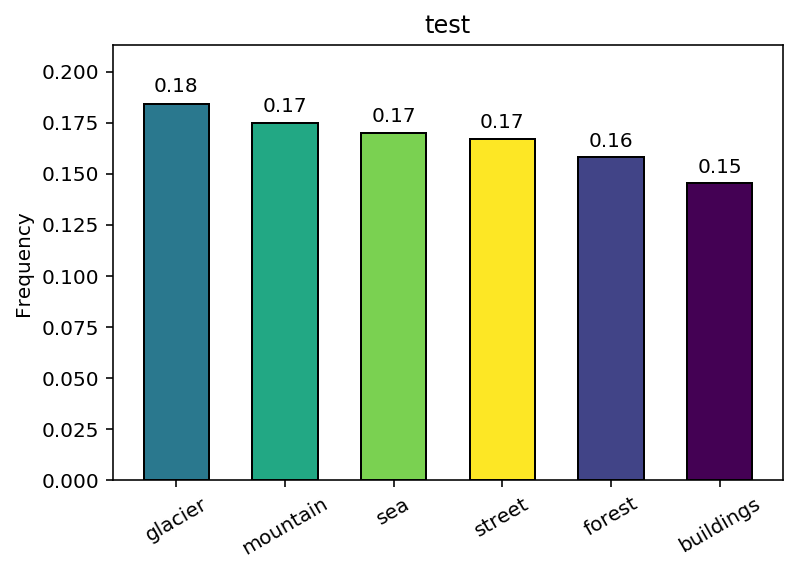

In [10]:
plot_label_dist(test_df, 'test')

In [11]:
def plot_random_img(df, label):
    
    subset = df.query("label == @label")
    random = subset.sample(1)
    
    img = Image.open(random['path'].values[0])
    img = np.array(img)
    
    plt.imshow(img)
    plt.title('{} - {}'.format(label, random['fn'].values[0]))
    plt.show()

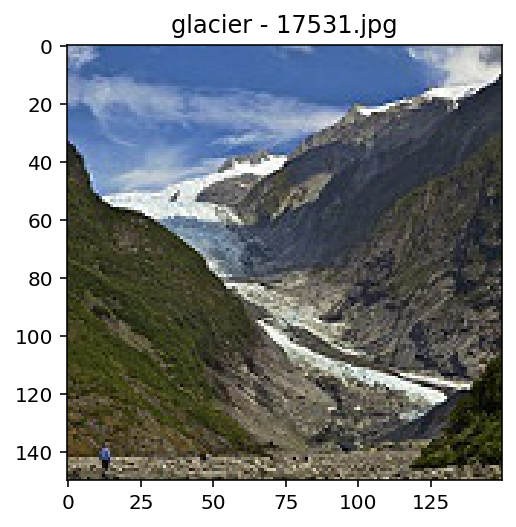

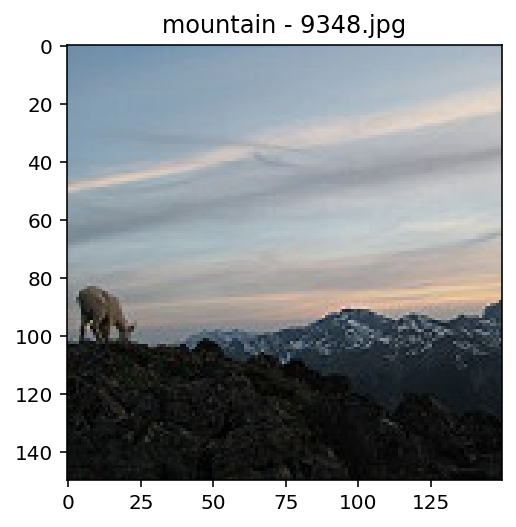

In [12]:
plot_random_img(train_df, 'glacier')
plot_random_img(train_df, 'mountain')

In [13]:
def plot_random_grid(df):
    
    '''plot 5x5 grid of random images'''
    
    fig, ax = plt.subplots(5, 5, figsize=(12, 12))
    
    for i in range(25):
        
        # shuffle data
        df_shuffle = df.sample(1)
        img = Image.open(df_shuffle['path'].values[0])
        img = np.array(img)
        ax.flat[i].imshow(img)
        ax.flat[i].axis('off')
        ax.flat[i].set_title('{}\n{}'.format(df_shuffle['label'].values[0], df_shuffle['fn'].values[0]),
                             size=9)
    
    plt.tight_layout()

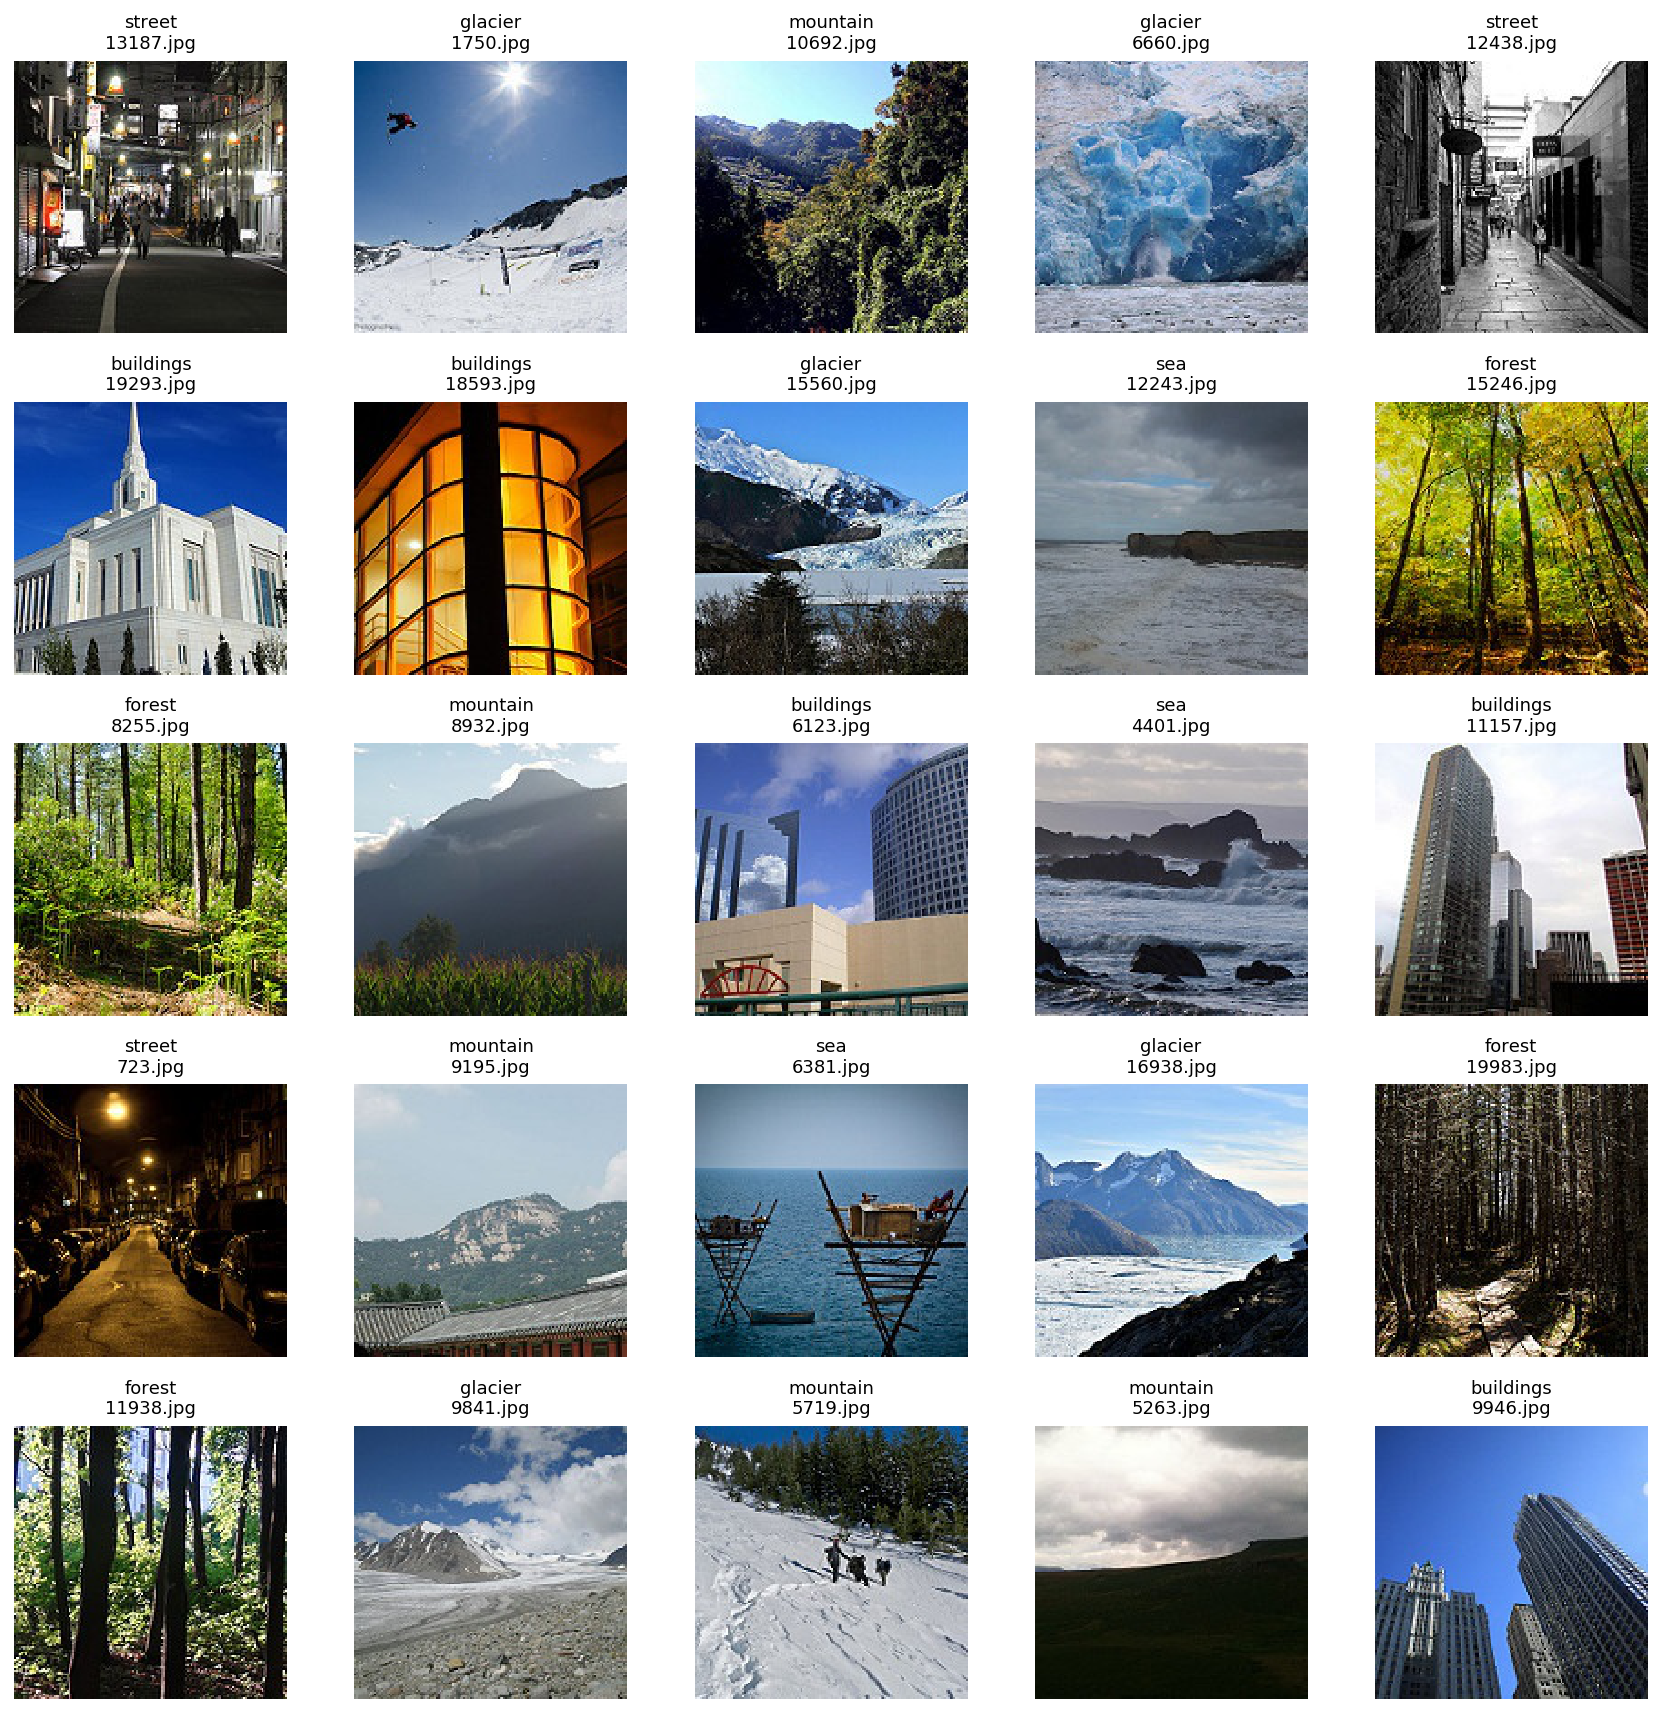

In [15]:
plot_random_grid(train_df)

In [154]:
# dataloader

class IntelData(Dataset):
    
    def __init__(self, df, transforms):
        
        self.x = df['path'].values
        self.y = df['label_num'].values
        self.transforms = transforms
    
    def __len__(self):
        
        return len(self.y)
    
    def __getitem__(self, idx):
        
        img = Image.open(self.x[idx])
        
        if self.transforms:
            img = self.transforms(img)
            
        path = self.x[idx]
            
        return img, self.y[idx], path

In [155]:
trans = transforms.Compose([transforms.Resize((150, 150)),
                            transforms.ToTensor()])

train_dataset = IntelData(train_df, trans)
test_dataset = IntelData(test_df, trans)

In [156]:
# dataloader

batch_size = 128

train_dl = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size)

In [157]:
# check dimensions

def check_dims(loader):

    for image, label, path in loader:
        print('image dim: {}'.format(image.shape))
        print('label dim: {}'.format(label.shape))
        break
    print('samples: {:,}'.format(len(loader.dataset)))
    print()

In [158]:
check_dims(train_dl)
check_dims(test_dl)

image dim: torch.Size([128, 3, 150, 150])
label dim: torch.Size([128])
samples: 14,034

image dim: torch.Size([128, 3, 150, 150])
label dim: torch.Size([128])
samples: 3,000



In [159]:
class ConvNet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        # [3, 150, 150] -> [32, 150, 150]
        # same padding
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        
        # [32, 150, 150] -> [32, 75, 75j]
        self.maxpool1 = nn.MaxPool2d(2)
        
        # [32, 75, 75] -> [32, 75, 75]
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        
        # [32, 75, 75] -> [32, 37, 37]
        self.maxpool2 = nn.MaxPool2d(2)
        
        # flatten [32, 37, 37] -> 43808 -> 128
        self.fc1 = nn.Linear(43808, 128)
        self.fc2 = nn.Linear(128, 6)
        
    def forward(self, x):
    
        x = self.maxpool1(F.relu(self.conv1(x)))
        x = self.maxpool2(F.relu(self.conv2(x)))
        
        # flatten
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        
        return x

In [160]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvNet()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [161]:
summary(model, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             896
         MaxPool2d-2           [-1, 32, 75, 75]               0
            Conv2d-3           [-1, 32, 75, 75]           9,248
         MaxPool2d-4           [-1, 32, 37, 37]               0
            Linear-5                  [-1, 128]       5,607,552
            Linear-6                    [-1, 6]             774
Total params: 5,618,470
Trainable params: 5,618,470
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 8.57
Params size (MB): 21.43
Estimated Total Size (MB): 30.27
----------------------------------------------------------------


In [165]:
def calc_acc(fx, y):
    
    preds = fx.argmax(1)
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float() / len(y)
    
    return acc

def train(epoch):
    
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for batch_idx, (image, label, path) in enumerate(train_dl):
        
        # to gpu
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        
        # forward and back
        output = model(image)
        loss = criterion(output, label)
        acc = calc_acc(output, label)
        
        loss.backward()
        optimizer.step()
        
        # metrics
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    # normalize by batches
    return epoch_loss / len(train_dl), epoch_acc / len(train_dl)


def test(epoch):
    
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch_idx, (image, label, path) in enumerate(test_dl):
            
            image, label = image.to(device), label.to(device)
            
            output = model(image)
            loss = criterion(output, label)
            acc = calc_acc(output, label)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(test_dl), epoch_acc / len(test_dl)

In [166]:
def fit_model(epochs):

    history = defaultdict(list)
    
    for epoch in range(epochs):
        
        start = time.time()
        train_loss, train_acc = train(epoch)
        test_loss, test_acc = test(epoch)
        end = time.time()
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        print('Epoch: {:02}'.format(epoch + 1))
        print('\tTrain Loss: {:.3f} | Train Acc: {:.3f}'.format(train_loss, train_acc))
        print('\tTest Loss:  {:.3f} | Test Acc:  {:.3f}'.format(test_loss, test_acc))
        print('\tepoch time: {:.2f}m'.format((end - start) / 60))
        
    return history

In [167]:
history = fit_model(10)

Epoch: 01
	Train Loss: 1.197 | Train Acc: 0.532
	Test Loss:  0.961 | Test Acc:  0.633
	epoch time: 0.47m
Epoch: 02
	Train Loss: 0.827 | Train Acc: 0.689
	Test Loss:  0.741 | Test Acc:  0.733
	epoch time: 0.35m
Epoch: 03
	Train Loss: 0.641 | Train Acc: 0.764
	Test Loss:  0.692 | Test Acc:  0.747
	epoch time: 0.36m
Epoch: 04
	Train Loss: 0.532 | Train Acc: 0.810
	Test Loss:  0.638 | Test Acc:  0.771
	epoch time: 0.37m
Epoch: 05
	Train Loss: 0.456 | Train Acc: 0.838
	Test Loss:  0.595 | Test Acc:  0.786
	epoch time: 0.39m
Epoch: 06
	Train Loss: 0.384 | Train Acc: 0.868
	Test Loss:  0.595 | Test Acc:  0.794
	epoch time: 0.36m
Epoch: 07
	Train Loss: 0.299 | Train Acc: 0.898
	Test Loss:  0.680 | Test Acc:  0.764
	epoch time: 0.37m
Epoch: 08
	Train Loss: 0.217 | Train Acc: 0.928
	Test Loss:  0.656 | Test Acc:  0.791
	epoch time: 0.35m
Epoch: 09
	Train Loss: 0.156 | Train Acc: 0.952
	Test Loss:  0.730 | Test Acc:  0.787
	epoch time: 0.37m
Epoch: 10
	Train Loss: 0.103 | Train Acc: 0.971
	Test L

In [168]:
def plot_history(history):
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    ax[0].plot(history['train_loss'], label='train', marker='^')
    ax[0].plot(history['test_loss'], label='test', marker='o')
    ax[0].set_title('Loss')
    ax[0].legend()
    ax[0].grid(alpha=0.2)
    ax[0].set_xlabel('epoch')
    
    ax[1].plot(history['train_acc'], label='train', marker='^')
    ax[1].plot(history['test_acc'], label='test', marker='o')
    ax[1].set_title('Accuracy')
    ax[1].legend()
    ax[1].grid(alpha=0.2)
    ax[1].set_xlabel('epoch')
    
    plt.tight_layout()

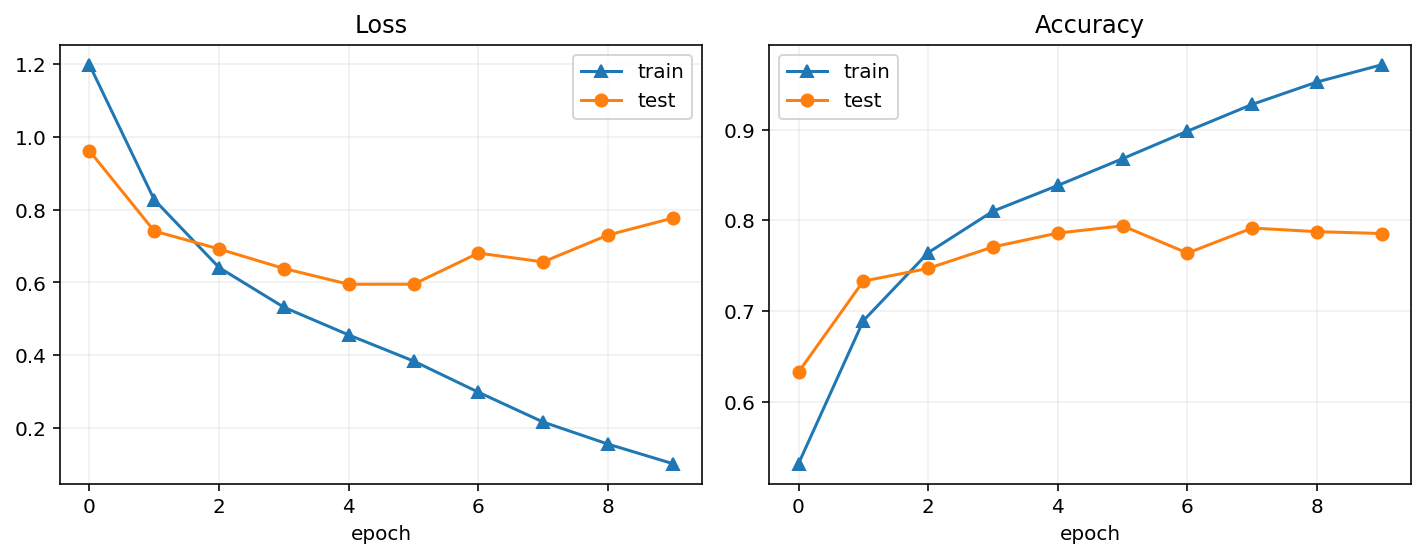

In [169]:
# overfitting
plot_history(history)

In [170]:
def plot_preds(df):
    
    '''plot 5x5 grid of images with predicted and true labels'''
    
    fig, ax = plt.subplots(5, 5, figsize=(14, 14))
   
    model.eval()
    for i in range(25):
        
        sample = df.sample(1)
        img = Image.open(sample['path'].values[0])
        ax.flat[i].imshow(img)
        
        img = trans(img).to(device)
        output = model(img.unsqueeze(0))
        pred = output.argmax(1)
        ax.flat[i].axis('off')
        
        fn = sample['fn'].values[0]
        lab = sample['label'].values[0]
        pred_lab = labels_to_class[pred.item()]
        
        ax.flat[i].set_title('{}\nTrue: {}\nPred: {}'.format(fn, lab, pred_lab),
                            size=8, color='r' if lab != pred_lab else 'g')
        
    plt.tight_layout()
    

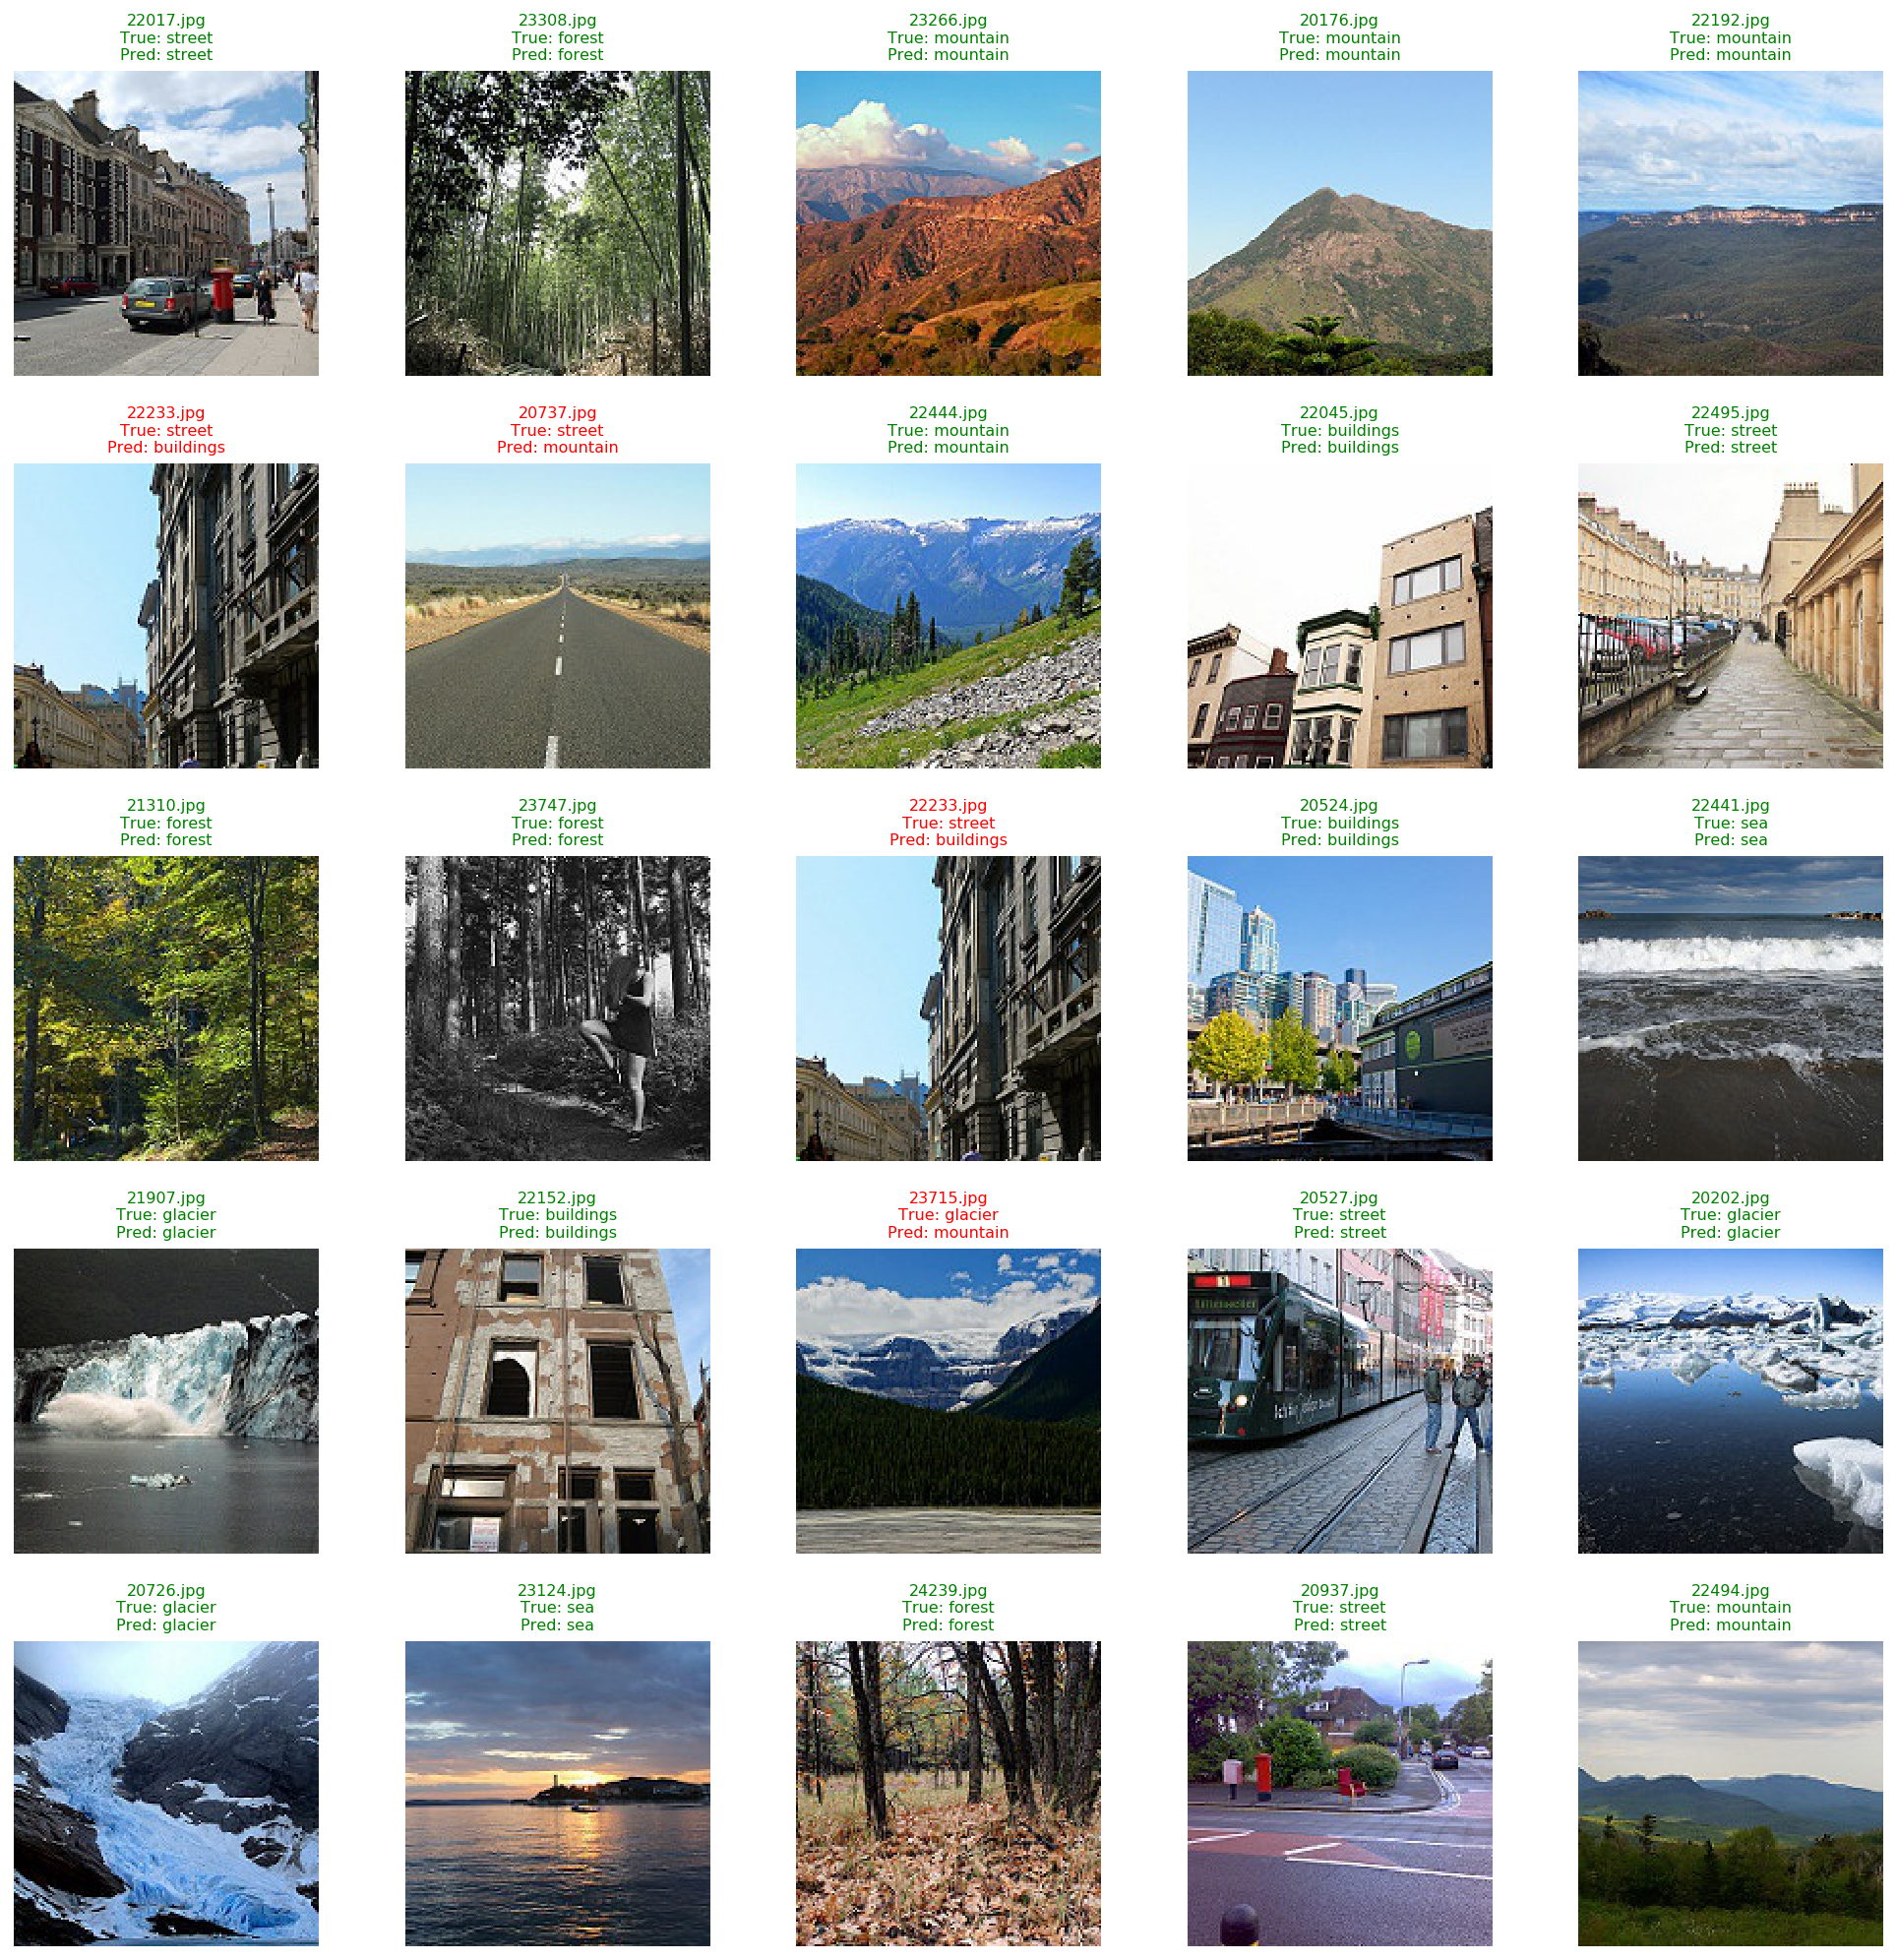

In [171]:
plot_preds(test_df)

In [185]:
def get_mislabeled_test():
    
    model.eval()
    
    # save incorrect predictions: img path, true label, predicted label
    wrong = []
    with torch.no_grad():
        
        for batch_idx, (image, label, path) in enumerate(test_dl):
            image, label = image.to(device), label.to(device)
    
            output = model(image)
            pred = output.argmax(1)
            
            for i, sample in enumerate(pred):
                if pred[i] != label[i]:
                    wrong.append([path[i], 
                                  labels_to_class[label[i].item()],
                                  labels_to_class[pred[i].item()]])
                    
    df = pd.DataFrame(wrong, columns=['path', 'true', 'pred'])
                    
    return df

def plot_mislabeled():
    
    # get wrongs and shuffle
    df = get_mislabeled_test()
    df = df.sample(frac=1)
    
    fig, ax = plt.subplots(5, 5, figsize=(14, 14))
    
    for i in range(25):
        
        lab = df['true'].values[i]
        pred_lab = df['pred'].values[i]
        
        img = Image.open(df['path'].values[i])
        ax.flat[i].imshow(img)
        ax.flat[i].set_title('True: {}\nPred: {}'.format(lab, pred_lab))
        ax.flat[i].axis('off')
        
    plt.tight_layout()

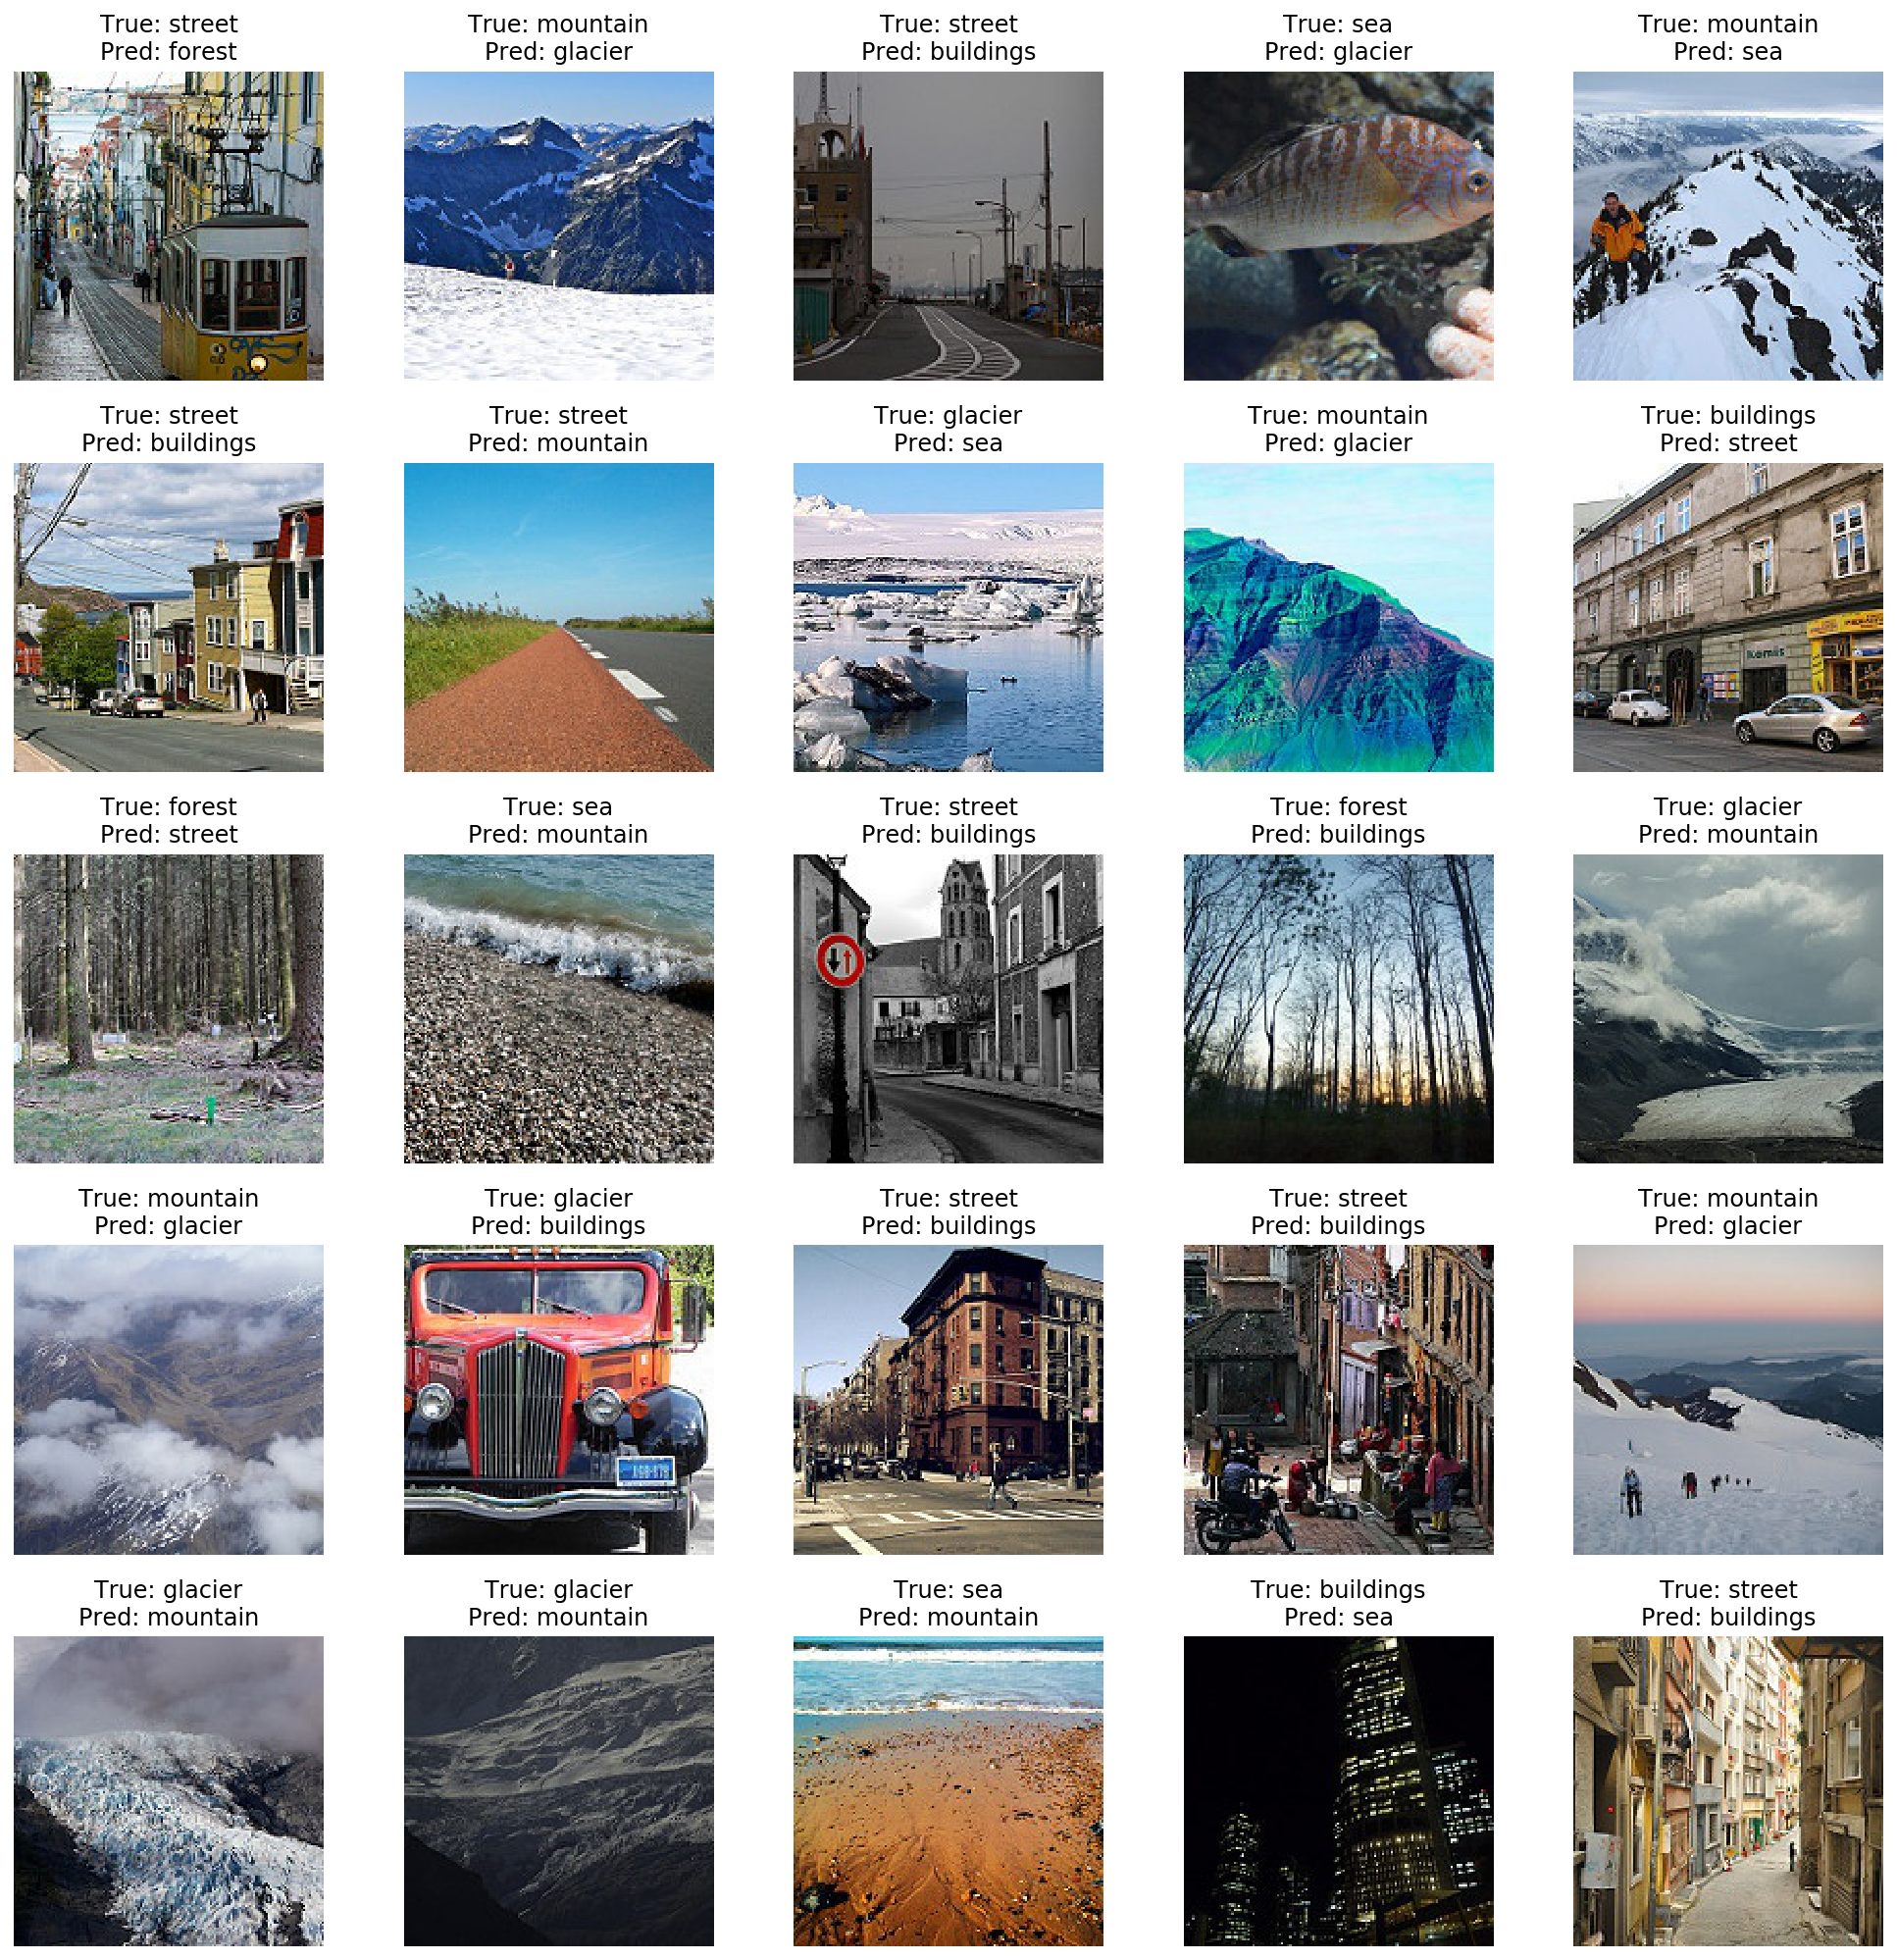

In [186]:
plot_mislabeled()

In [203]:
def pred_on_test():
    
    model.eval()
        
    pred_labels = []
    test_labels = []
    
    with torch.no_grad():
        for batch_idx, (image, label, path) in enumerate(test_dl):
            
            image, label = image.to(device), label.to(device)
            output = model(image)
            
            pred = output.argmax(1)
            
            pred_labels.append(pred)
            test_labels.append(label)
            
    # cat together
    pred_labels = torch.cat(pred_labels).cpu().numpy()
    test_labels = torch.cat(test_labels).cpu().numpy()
    
    return test_labels, pred_labels

In [204]:
test_labels, pred_labels = pred_on_test()

In [281]:
def plot_confusion(test_labels, pred_labels):
    
    fig = plt.figure(figsize=(5, 5))
    
    cm = confusion_matrix(test_labels, pred_labels)
    print(cm)
    
    g = plt.imshow(cm, cmap=plt.cm.plasma)
    plt.colorbar(g, shrink=0.7)
    plt.title('confusion matrix')
    
    xra = range(len(np.unique(test_labels)))
    xla = [labels_to_class[x] for x in xra]
    
    plt.xticks(xra, xla, rotation=45, ha='right', rotation_mode='anchor')
    plt.yticks(xra, xla)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = plt.text(i, j, cm[j, i],
                            ha='center', va='center', color='w' if cm[j, i] < 200 else 'k')
            
    

[[322   6   8  18  35  48]
 [ 19 429   2   4   3  17]
 [  6   4 412  92  36   3]
 [  5   1  65 419  35   0]
 [ 13   2  35  48 406   6]
 [ 88  14   9   8  15 367]]


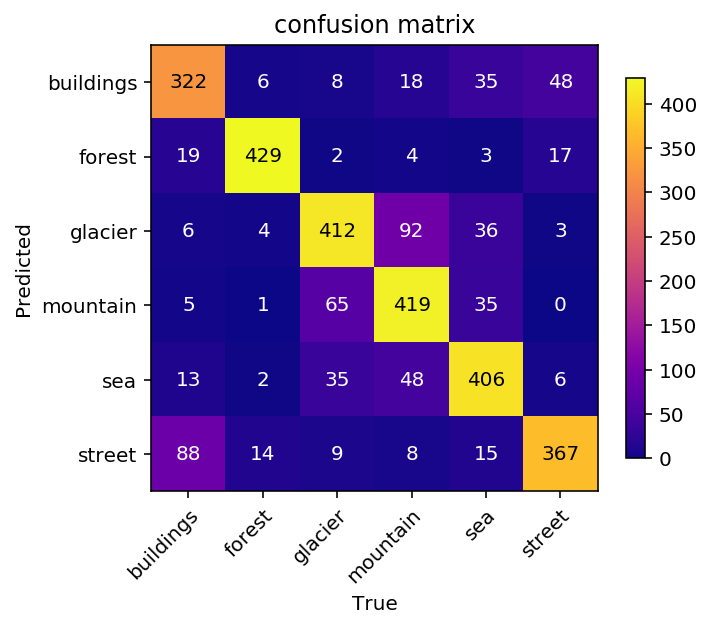

In [282]:
plot_confusion(test_labels, pred_labels)

In [334]:
# feature extractor
feat_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = (0.485, 0.456, 0.406),
                                                           std = (0.229, 0.224, 0.225))])

train_feat = IntelData(train_df, feat_transforms)
test_feat = IntelData(test_df, feat_transforms)

train_feat_loader = DataLoader(train_feat, batch_size = 128, shuffle=True)
test_feat_loader = DataLoader(test_feat, batch_size = 128, shuffle=True)

In [335]:
vgg19 = models.vgg19(pretrained=True)

In [336]:
for param in vgg19.parameters():
    param.requires_grad=False

In [380]:
def extract(loader):
    
    out = torch.FloatTensor()
    labels = torch.LongTensor()
    
    for batch_idx, (image, label, path) in enumerate(loader):
        
        feature_map = vgg19.features(image)
        out = torch.cat((out, feature_map.view(feature_map.shape[0], -1)), dim=0)
        labels = torch.cat((label, labels), dim=0)
        
        if batch_idx >= 3:
            break
    
    return out.cpu().numpy(), labels.cpu().numpy()

In [381]:
feats, labs = extract(train_feat_loader)
feats.shape, labs.shape

((512, 25088), (512,))

In [382]:
#pca = make_pipeline(StandardScaler(), PCA(n_components=2))
pca = make_pipeline(PCA(n_components=2))
pca_feats = pca.fit_transform(feats)

Text(0.5, 1.0, 'PCA projection')

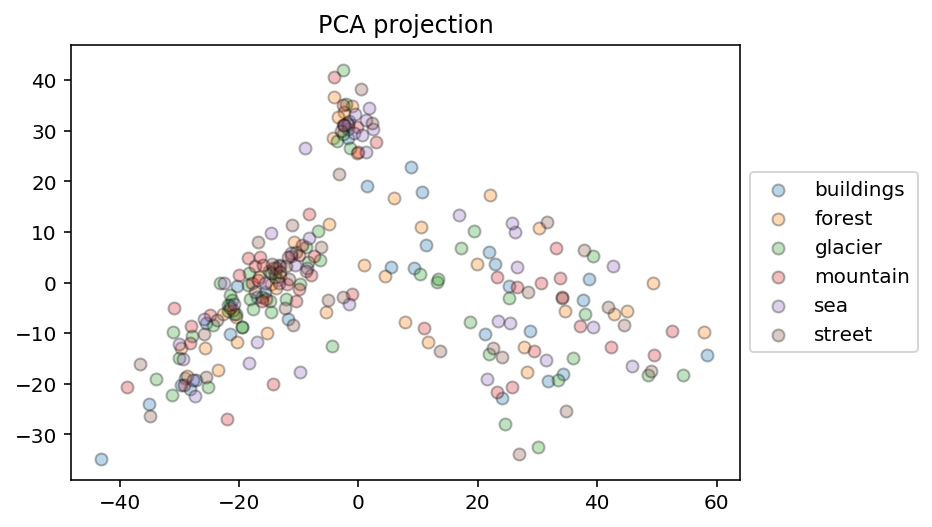

In [383]:
fig = plt.plot(figsize=(5, 5))

for lab in np.unique(labs):
    x = np.where(test_labs == lab)
    plt.scatter(pca_feats[x, 0], pca_feats[x, 1], alpha=0.3, 
                label=labels_to_class[lab], edgecolor='k')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('PCA projection')